In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


# **Step - 0: Determining the objective**

## **Problem statement:**

- Credit card fraud detection is an immenent problem to every company in the banking industry. Detecting and preventing credit card fraud is a necessity for banks.
- Hence, our objective here is to develop a machine learning model that detects fraudulent transactions based on the historical transactional data of customers with a pool of merchants and provide a cost benefit analysis of the model to the stakeholders and provide them with appropriate recommendations to adopt in order to mitigate fraud risks.

# **Step - 1: Understanding Data :**

In [2]:
#importing required packages

#modelues for EDA steps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modules for data cleaning and data analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

#modules for model building
#algorithms for sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#baseline linear model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#modules for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#modules for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

#modules for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

#setting backend for matplotlib
%matplotlib inline

#setting formatting options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 900
pd.set_option('float_format' , '{:f}'.format)

#setting plot style
plt.style.use('seaborn-darkgrid')

In [3]:
#loading the dataset
fraud_train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
fraud_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

#concatenating the two datasets
df = pd.concat([fraud_train, fraud_test]).reset_index()

df.drop(df.columns[:2], axis=1, inplace=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


#### **Data Dictionary**
- <b>trans_date_trans_time -></b> Transaction time stamp
- <b>cc_num -></b> Credit card number
- <b>merchant -></b> merchant name
- <b>category -></b> transaction category
- <b>amt -></b> Transaction amount
- <b>first -></b> First name of card holder
- <b>last -></b> Last name of card holder
- <b>gender -></b> Sex of card holder
- <b>street -></b> transaction address
- <b>city -></b> transaction city
- <b>state -></b> transaction state
- <b>zip -></b> transaction zipcode
- <b>lat -></b> transaction lattitude
- <b>long -></b> transaction longitude
- <b>city_pop -></b> Population of the city
- <b>job -></b> job of the card holder
- <b>dob -></b> date of birth of card holder
- <b>trans_num -></b> transaction number of transaction
- <b>unix_time -></b> time in unix format
- <b>merch_lat -></b> lattitude of the merchant
- <b>merch_long -></b> longitude of merchant
- <b>is_fraud -></b> nature of transaction (fraud or not fraud)

- Here, the `'is_fraud'` variables is our target variable.

# **Step - 2: Data pre-processing**

- Here, we need to convert the trans_date_trans_time column into datetime format

In [4]:
#converting trans_date_trans_time into datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
print(df.dtypes['trans_date_trans_time'])
df.head()

datetime64[ns]


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


- Now, let us check the data balance in the dataset in the 'is_fraud' column, i.e., our target variable.

In [5]:
#let us look at the number of unique values in the dataset
df.nunique()

trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

- Now, since there are a lot of unique values in the 'trans_date_trans_time' column, we will now separate the column into hour, day, and Month-year, in order to get more information from the column and attach these additonal columns to our original dataframe

In [6]:
# deriving additonal columns from 'trans_date_trans_time'
#deriving hour
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
#deriving 'day of the week'
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.day_name()
#deriving 'year_month'
df['trans_year_month'] = df['trans_date_trans_time'].dt.to_period('M')

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01


- Let us now also find the age of the customer at the time of transacting.
- This variable might help us in identifiying which age group of people are being subject to fraud.

In [7]:
#finding age
#converting 'dob' column to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - 
                      df['dob'])/np.timedelta64(1, 'Y'))
df.age.head()

0   31.000000
1   41.000000
2   57.000000
3   52.000000
4   33.000000
Name: age, dtype: float64

- Now, since we have extracted separate variables from the 'trans_date_trans_time' column, it is safe to drop the column, since it does not provide us any additonal information.
- And, since we have also extracted the age of the customers, we can safely remove the 'dob' variable too since it does not provide us any additonal information in this context.
- Also, the variables 'first', 'last' contain personally identifiable information. These features cause privacy concerns and moreover are not necessary in the context of our analysis. Therefore, we will drop these variables too.

In [8]:
#dropping variables
df.drop(['trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,31.000000
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,41.000000
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,57.000000
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,52.000000
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,33.000000


- Now that our dataframe has only the required data, we will now proceed to the Data processing step, i.e., handling missing values, encoding variables and scaling variables wherever required.

In [9]:
#checking the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column             Dtype    
---  ------             -----    
 0   cc_num             int64    
 1   merchant           object   
 2   category           object   
 3   amt                float64  
 4   gender             object   
 5   street             object   
 6   city               object   
 7   state              object   
 8   zip                int64    
 9   lat                float64  
 10  long               float64  
 11  city_pop           int64    
 12  job                object   
 13  trans_num          object   
 14  unix_time          int64    
 15  merch_lat          float64  
 16  merch_long         float64  
 17  is_fraud           int64    
 18  trans_hour         int64    
 19  trans_day_of_week  object   
 20  trans_year_month   period[M]
 21  age                float64  
dtypes: float64(6), int64(6), object(9), period[M](1)
memory usage: 310

- Here object, int, float as well as datetime data types exist this confirms that some data type conversion is required in the data celaning step

- The features with object data type have to converted into a format that can be modelised, for this we will encode the these categorical values in the later part of our analysis

- However, there are no missing values in the dataset.

In [10]:
#storing a copy
df_org = df.copy()

# **Step - 3: Exploratory Data Analysis [EDA]**

In [11]:
#determing the shape of the dataset
df.shape

(1852394, 22)

In [12]:
#checking the dataframe
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,31.000000
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,41.000000
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,57.000000
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,52.000000
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,33.000000


In [13]:
#describing the dataset
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,trans_hour,age
count,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000
mean,417386038393710400.000000,70.063567,48813.258191,38.539311,-90.227832,88643.674509,1358674218.834364,38.538976,-90.227940,0.005210,12.806119,46.266173
std,1309115265318734848.000000,159.253975,26881.845966,5.071470,13.747895,301487.618344,18195081.387560,5.105604,13.759692,0.071992,6.815753,17.412388
min,60416207185.000000,1.000000,1257.000000,20.027100,-165.672300,23.000000,1325376018.000000,19.027422,-166.671575,0.000000,0.000000,14.000000
25%,180042946491150.000000,9.640000,26237.000000,34.668900,-96.798000,741.000000,1343016823.750000,34.740122,-96.899440,0.000000,7.000000,33.000000
50%,3521417320836166.000000,47.450000,48174.000000,39.354300,-87.476900,2443.000000,1357089331.000000,39.368900,-87.440694,0.000000,14.000000,44.000000
75%,4642255475285942.000000,83.100000,72042.000000,41.940400,-80.158000,20328.000000,1374581485.250000,41.956263,-80.245108,0.000000,19.000000,57.000000
max,4992346398065154048.000000,28948.900000,99921.000000,66.693300,-67.950300,2906700.000000,1388534374.000000,67.510267,-66.950902,1.000000,23.000000,96.000000


In [14]:
#let us check the percentage of fraudulent data points in our dataset
100*df.is_fraud.value_counts(normalize=True)

0   99.478999
1    0.521001
Name: is_fraud, dtype: float64

- The above output indicates that percentage of fradulent transaction in the dataset is only about 0.57% but the percentage of non-fraudulent transactions in 99.42%.
- Therefore, this is an imbalanced dataset and there is a need to balance the data, in order to not produce any biases in our analysis.

### **Exploring Amount('amt') data:**
- Amount is an important variable in credit card fraud analysis.
- we will now look at the amount distribution and try to bring out some insights from the same.

*Let us now look at the distribution of the overall amount, the fraud amount and the non-fraud amount.*

In [15]:
#looking at distribution of amount
pd.concat(
    [df['amt'].describe(percentiles = [0.5,0.95,0.999]).reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
     df.loc[df['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Non-Fraud Amt Distribution'}),
     df.loc[df['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})], axis=1)

,Row Type,Overall Amt Distribution,Non-Fraud Amt Distribution,Fraud Amt Distribution
0,count,1852394.000000,1842743.000000,9651.000000
1,mean,70.063567,67.651278,530.661412
2,std,159.253975,153.548108,391.028873
3,min,1.000000,1.000000,1.060000
4,50%,47.450000,47.240000,390.000000
5,95%,195.340000,189.590000,1084.090000
6,99.9%,1517.241050,1519.622580,1293.127000
7,max,28948.900000,28948.900000,1376.040000


- *The mean of the 'non-fraud amt distribution' is far less than the 'fraud amt distribution'.*
- *This means that in a given set of transaction with balanced number of fraud and non-fraud data points, the mean transaction amount of fraud amt is very high. This implies that the amount lost in a fraud trnasaction is very high.*

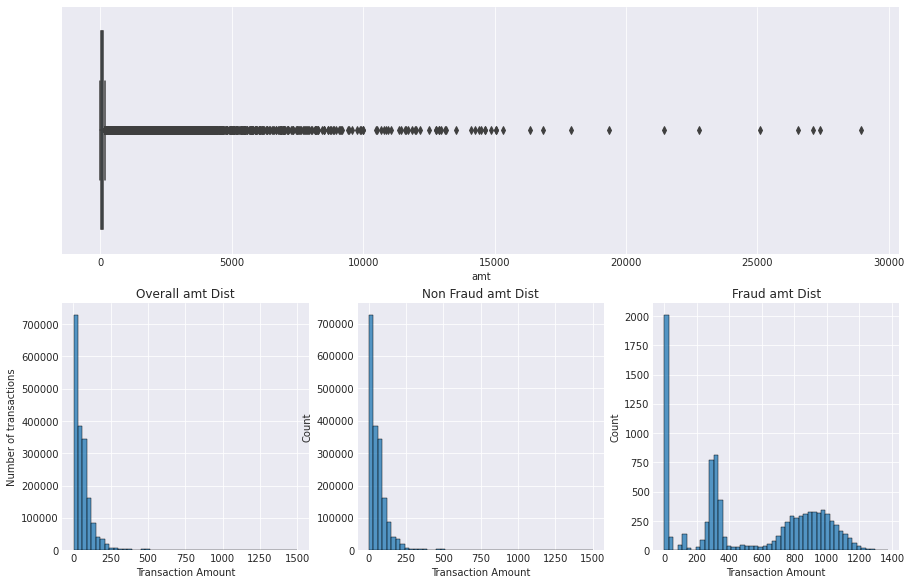

In [16]:
#plotting the above distributions
fig = plt.subplots(figsize=(15,10))

plots = []
#plotting the amt feature
#box plot
plots.append(sns.boxplot(df.amt, ax=plt.subplot(211)))

#distribution plots
plots.append(sns.histplot(df[df.amt <= 1500].amt, bins=50, ax=plt.subplot(234)))
plots.append(sns.histplot(df[(df.is_fraud==0) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(235)))
plots.append(sns.histplot(df[(df.is_fraud==1) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(236)))

#setting titles
plots[1].set_title('Overall amt Dist')
plots[2].set_title('Non Fraud amt Dist')
plots[3].set_title('Fraud amt Dist')

#setting x labels
plots[1].set_xlabel('Transaction Amount')
plots[2].set_xlabel('Transaction Amount')
plots[3].set_xlabel('Transaction Amount')

#setting y label
plots[1].set_ylabel('Number of transactions')

plt.show()

##### **Observation ('amt' Feature):**
- From the above plots, it can be noted that the 'amt' feature has a lot of outliers. This means that, the variance in the feature is huge.
- The distribution of the overall amount and the non fraud amount are similar with similar means. However, the mean of the fraud amount plot seems more than that of the other distributions.
- Also, the skewness in the data can be clearly seen.

##### **Inference:**
- From the above plot, though the mean of the fraud amount seems to be more than that of the non fraud or the overall amount, it can be observed that the fraud amount is evenly distributed and often records low amount value as compared to the other distributions.
- From this, it can be observed that the fraud amount transaction often happens in small amount, often aroung 200 and at times in the range of 200 to 400.
- Therefore, the transactions in which small amount is involved can be monitored more closely in order to detect and prevent credit card fraud.

### **Exploring Time data:**

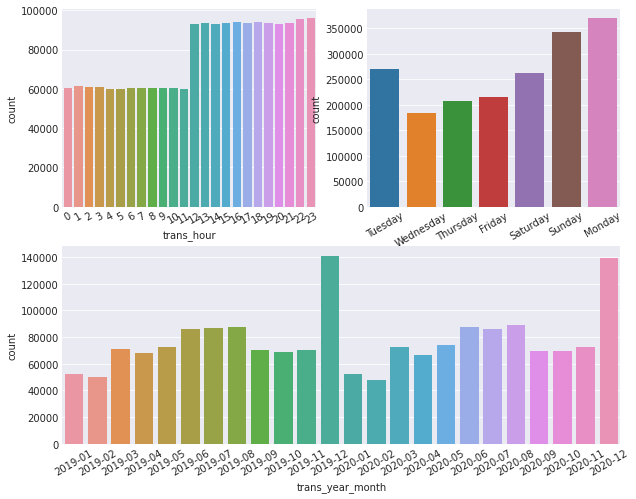

In [17]:
fix, ax = plt.subplots(figsize=(10,8))

plot = [0,0,0]
#plotting the 'trans_hour' feature
plot[0] = sns.countplot(df.trans_hour, ax = plt.subplot(221))
#plotting the 'trans_day_of_week' feature
plot[1] = sns.countplot(df.trans_day_of_week, ax = plt.subplot(222))
#plotting the 'trans_year_month' feature
plot[2] = sns.countplot(df.trans_year_month, ax = plt.subplot(212))

for i in plot:
  i.set_xticklabels(i.get_xticklabels(), rotation=30)
plt.show()

- *Now, let us view these plots with respect to the amount distributions.*

In [18]:
#year_month vs number of transactions
df_timeline01 = df.groupby(df['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline01.columns = ['year_month','num_of_transactions','customers']
df_timeline01

,year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


*Now, let us plot the above distribution*

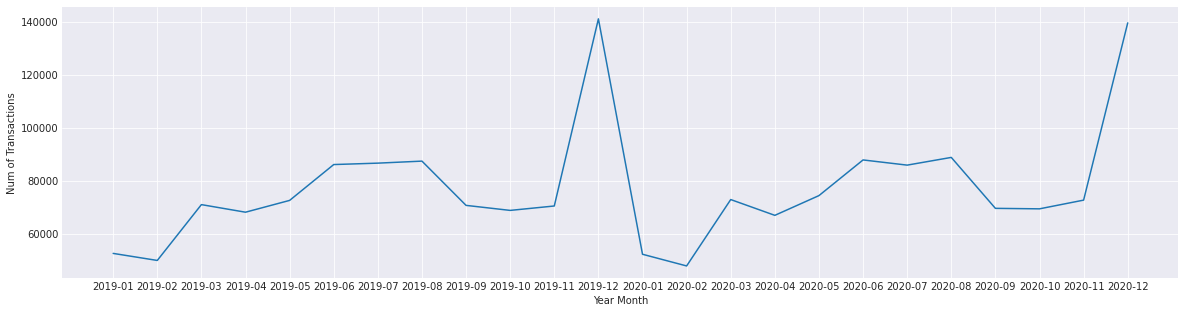

In [19]:
x = np.arange(0,len(df_timeline01),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline01['num_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline01['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Num of Transactions')
plt.show()

- *year_month vs fraud trasactions and fraud customers.*

In [20]:
df_fraud_transactions = df[df['is_fraud']==1]

df_timeline02 = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline02.columns = ['year_month','num_of_fraud_transactions','fraud_customers']
df_timeline02

,year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


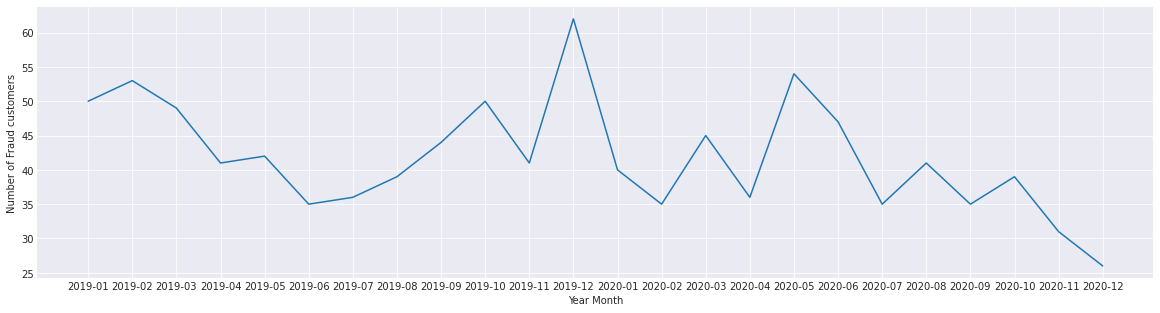

In [21]:
x = np.arange(0,len(df_timeline02),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline02['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline02['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Number of Fraud customers')
plt.show()


#### **Observation (Time data):**
- From the above visualizations it can be deduced that, the most number of transactions happened in the afternoon times of the day, i.e., after 12 pm in the afternoon.
- Also, most of the transactions according to the 'trans_week' data have happened during 'sunday' and 'monday' weekdays of the week.
- Moreover, according to the 'trans_year_month' data, most transactions have happened in the January, February, October, December months of 2019 and in the May month of 2020.
- Also, it can be noted that the number of fraud customers and the number of fraud transaction have increased in the time of December, which again is the holiday season.

#### **Inference:**
- It can be observed that since most of the transaction happen after the noon hour of the day, the surveilance can be increased upon the transactions after 12pm in the day in order to reduce fraudulent transactions.
- In the holiday seasons like the 12th month of december, the number of transactions increase, such times can be monitored closely in order to reduce fraudulent transactions.
- Also, in the holiday season most people tend to go for shopping and other recreational and cultural activities during which people might be using their credit cards for various purposes. And hence, merchants in such a domain can be checked and educated about the fradulent practices happening.

### **Exploring Gender data:**

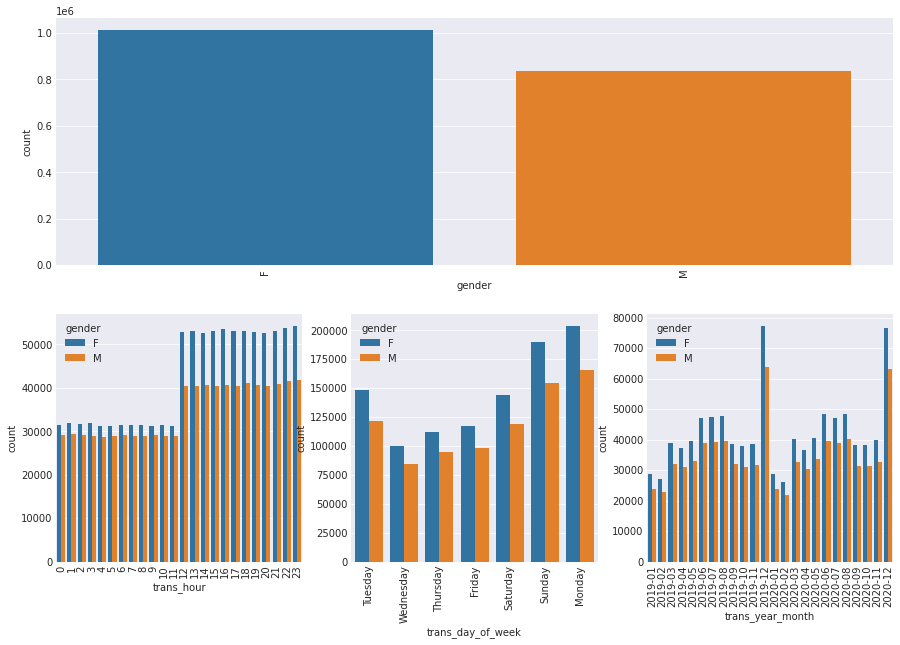

In [22]:
fig, ax = plt.subplots(figsize=(15,10))

plot = [0,0,0,0]
#plotting gender demographic with respect to transactions
plot[0] = sns.countplot(df.gender, ax=plt.subplot(211))
#plotting transactions over time, with respect to gender
plot[1] = sns.countplot(df.trans_hour, hue=df.gender, ax=plt.subplot(234))
plot[2] = sns.countplot(df.trans_day_of_week, hue=df.gender, ax=plt.subplot(235))
plot[3] = sns.countplot(df.trans_year_month, hue=df.gender, ax=plt.subplot(236))

for i in plot:
  i.set_xticklabels(i.get_xticklabels(), rotation=90)
plt.show()

- *Now, let us view the gender feature against the is_fraud feature.*

In [23]:
#creating the 'gender' distributed dataframe
df_gender = df[['gender','trans_num']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender', 'gender_count']

#creating gender-fraud distribution
df_fraud_gender = df[['gender','trans_num', 'is_fraud']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender', 'is_fraud', 'Transaction Count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender', 'gender_count']], how='inner', on='Gender')

df_fraud_gender['Transaction percentage'] = (df_fraud_gender['Transaction Count']/df_fraud_gender['gender_count'])*100

df_fraud_gender

,Gender,is_fraud,Transaction Count,gender_count,Transaction percentage
0,F,0,1009850,1014749,99.517221
1,F,1,4899,1014749,0.482779
2,M,0,832893,837645,99.432695
3,M,1,4752,837645,0.567305


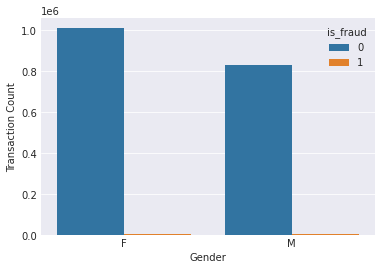

In [24]:
sns.barplot(data=df_fraud_gender, y='Transaction Count', x='Gender', hue='is_fraud')

plt.show()

##### **Observation:**
- From the above visualization it can be observed that women contribute the most to the amount of the transaction frequencies.
- Although women do participate in fraud, the amount of women involved in fraud with respect to the number of transactions involving women is 0.52% whereas the same for men is about 0.64%.

#### **Inference:**
- It can be concluded that women are involved in most of the transactions and hence, they be more prone to frauds.
- Therefore, while there is a need for all sexes in the data to be knowledgable about the frauds and their methods happening due to credit cards, in order to reduce the amount of frauds women should be educated and trained to be a bit more vigilant since they are much more prone to frauds.
- It can be conluded that men are a bit more inclined to be involved in fraud alothough both the sexes appear to be almost equally involved in all fraudulent transactions

### **Exploring Age data:**

- Let us now plot the age the variable with respect to the number fof transactions.
- This plot will give us an overview of the number of transaction being carried out by different age groups in the data.
- the Age

In [25]:
#let us first bin the age feature
for i in range(len(df.age)):
  if df.age[i] <= 30:
    df.age[i] = '< 30'
  elif df.age[i] > 30 and df.age[i] <= 45:
    df.age[i] = '30-45'
  elif df.age[i] > 45 and df.age[i] <= 60:
    df.age[i] = '46-60'
  elif df.age[i] > 60 and df.age[i] <= 75:
    df.age[i] = '61-75'
  else:
    df.age[i] = '> 75'

df.age.head()

0    30-45
1    30-45
2    46-60
3    46-60
4    30-45
Name: age, dtype: object

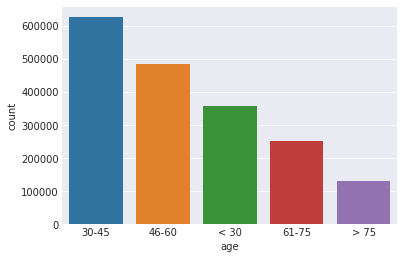

In [26]:
#plotting the age feature in the data
plot = sns.countplot(df.age)

plt.show()

- *Now, let us view the 'age' feature with respect to the 'is_fraud' variable.*

In [27]:
#constructing the age-transaction count distribution
df_age = df[['age','trans_num']].groupby(['age']).count().reset_index()
df_age.columns = ['age', 'age_count']

#creating the age-fraud distribution
df_fraud_age = df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'Transaction count']

df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

df_fraud_age['Transaction percentage'] = (df_fraud_age['Transaction count']/df_fraud_age['age_count'])*100

df_fraud_age

,age,is_fraud,Transaction count,age_count,Transaction percentage
0,30-45,0,624194,626681,99.603147
1,30-45,1,2487,626681,0.396853
2,46-60,0,481947,484709,99.430174
3,46-60,1,2762,484709,0.569826
4,61-75,0,250757,252266,99.401822
5,61-75,1,1509,252266,0.598178
6,< 30,0,355435,357316,99.473575
7,< 30,1,1881,357316,0.526425
8,> 75,0,130410,131422,99.229961
9,> 75,1,1012,131422,0.770039


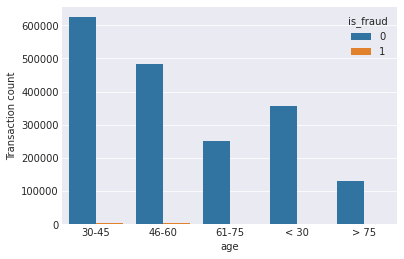

In [28]:
sns.barplot(data=df_fraud_age, y='Transaction count', x='age', hue='is_fraud')

plt.show()

###### **Observation (Age groups):**
- from the above plots it can be observed that the most number of transactions in the datset have been done by the people in the 30-45 age group.
- Also, the 46-60 age group has done significant number of transactions.
- With respect to the total number of transaction made by a particular age group the people in the >75 age group are the most affected, wherein, about 1% transaction made by these people have been fraudulent.

###### **Inference:**
- These are the people that are much prone to frauds and hence their transactions can be monitored with much more vigilance and they need to be educated regarding the frauds happening in order to reduce fraudulent transactions.
- The old age people might be targeted by fraudsters to take advantage of their lack of knowledge towards fina

### **Exploring State data:**

In [29]:
df.state.nunique()

51

- since there are a lot of categories in the 'state' variable of the data, we will now only look at the top 20 states wherein the transaction frequencies are the highest.

In [30]:
#fetching states with high transaction frequecy
high_trans_states = df.state.value_counts().head(20).index.tolist()
print(high_trans_states)

['TX', 'NY', 'PA', 'CA', 'OH', 'MI', 'IL', 'FL', 'AL', 'MO', 'MN', 'AR', 'NC', 'VA', 'WI', 'SC', 'KY', 'IN', 'IA', 'OK']


In [31]:
100*df[df.state.isin(high_trans_states)].state.value_counts(normalize=True)

TX   10.961858
NY    9.677414
PA    9.252292
CA    6.523111
OH    5.399284
MI    5.334292
IL    5.041503
FL    4.925052
AL    4.742394
MO    4.449281
MN    3.681776
AR    3.615163
NC    3.495470
VA    3.383801
WI    3.382342
SC    3.381775
KY    3.320997
IN    3.204141
IA    3.144578
OK    3.083476
Name: state, dtype: float64

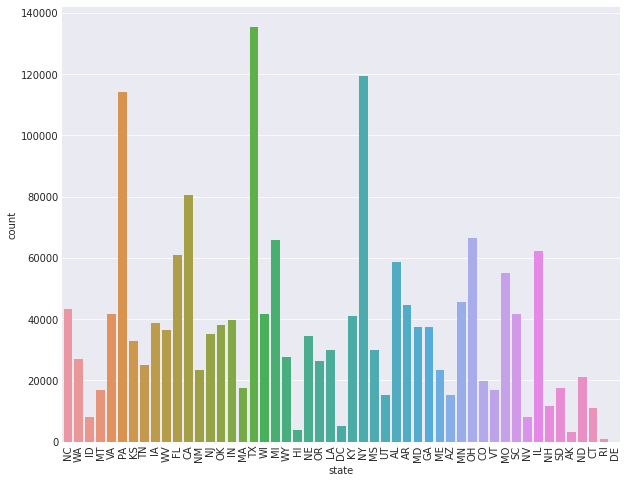

In [32]:
#let us now explore the city, zip and state features
fig, ax = plt.subplots(figsize=(10,8))

#plotting state feature
plot = sns.countplot(df.state)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

- *Now, let us see the State - fraud distribution in the given dataframe.*

In [33]:
#constructing the state-transaction count distribution
df_state = df[['state','trans_num']].groupby(['state']).count().reset_index()
df_state.columns = ['state', 'state_count']

#creating the state-fraud distribution
df_fraud_state = df[['state', 'trans_num', 'is_fraud']].groupby(['state','is_fraud']).count().reset_index()
df_fraud_state.columns = ['state', 'is_fraud', 'Transaction count']

df_fraud_state = df_fraud_state.merge(df_state[['state', 'state_count']], how='inner', on='state')

df_fraud_state['Transaction percentage'] = (df_fraud_state['Transaction count']/df_fraud_state['state_count'])*100

#viewing the top 20 states with high fraudulent transactions
df_fraud_state[df_fraud_state['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,state,is_fraud,Transaction count,state_count,Transaction percentage
16,DE,1,9,9,100.000000
78,RI,1,15,745,2.013423
1,AK,1,50,2963,1.687479
74,OR,1,197,26408,0.745986
60,NH,1,79,11727,0.673659
90,VA,1,273,41756,0.653798
84,TN,1,159,24913,0.638221
58,NE,1,216,34425,0.627451
46,MN,1,280,45433,0.616292
68,NY,1,730,119419,0.611293


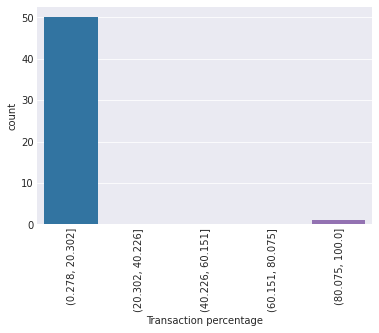

In [34]:
#plotting the fraudulent transactions percentage by binning
plot = sns.countplot(pd.cut(df_fraud_state[df_fraud_state.is_fraud == 1]['Transaction percentage'], bins = 5))
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [35]:
#states with more than 75% fraudulent transactions
print('state with more than 75% fraudulent transactions:\n')
print(df_fraud_state.loc[(df_fraud_state.is_fraud == 1) & (df_fraud_state['Transaction percentage'] >= 75)].state)

state with more than 75% fraudulent transactions:

16    DE
Name: state, dtype: object


#### **Observation (State feature):**
- The states 'PA', 'TX', 'NY' have the most amount of transactions noted in the given dataset.
- The next highest in the list are 'FL', 'CA', 'MI', 'AL', 'OH' and 'IL'.
- Majority of the transactions are happening in these states, and hence there is a high chance of fraudulent transaction happening in these states thourgh various methods including ATM and POS machine tamperings.
- In the top 20 states with high transaction volumes, it can be noted that all states have a fraudulent transaction of about 0.5%.
- 'DE' is the most fraudulent state.

#### **Inference:**
- In view of the above observations, it can be concluded that in order to reduce the number of fraudulent transactions overall, it is necessary that the monitoring of transactions in areas where in the most number of transaction must be increased.
- Therefore, the people in these areas could be alerted about the fradulent practices and can be adviced to follow the best practices to reduce the number of credit card frauds.

### **Exploring 'city' and 'zip' variables:**

In [36]:
print('number of cities: ',df.city.nunique())
print('number of zip codes: ',df.zip.nunique())

number of cities:  906
number of zip codes:  985


- It can be observed that it is difficult to plot a feature with such high number of unique values.
- Now, there is very high of chance of frauds happening in the cities or zip codes where there are very high transaction frequencies.
- Since it is difficult to visualize all the categories of cities at the same time we will now visualize the top 20 cities and top 20 zip codes with high transaction frequencies.

In [37]:
high_trans_cities = df.city.value_counts().head(20).index.tolist()
high_trans_zips = df.zip.value_counts().head(20).index.tolist()
print('high frequencies cities: ', high_trans_cities)
print('high frequencies zip codes: ', high_trans_zips)

high frequencies cities:  ['Birmingham', 'San Antonio', 'Utica', 'Phoenix', 'Meridian', 'Warren', 'Conway', 'Cleveland', 'Thomas', 'Houston', 'Arcadia', 'Naples', 'Brandon', 'Fulton', 'Indianapolis', 'Burbank', 'Dallas', 'Washington', 'Detroit', 'Hudson']
high frequencies zip codes:  [82514, 73754, 48088, 34112, 61454, 16114, 89512, 72476, 84540, 72042, 33872, 46346, 12419, 29438, 15484, 5461, 85173, 6024, 7060, 58569]


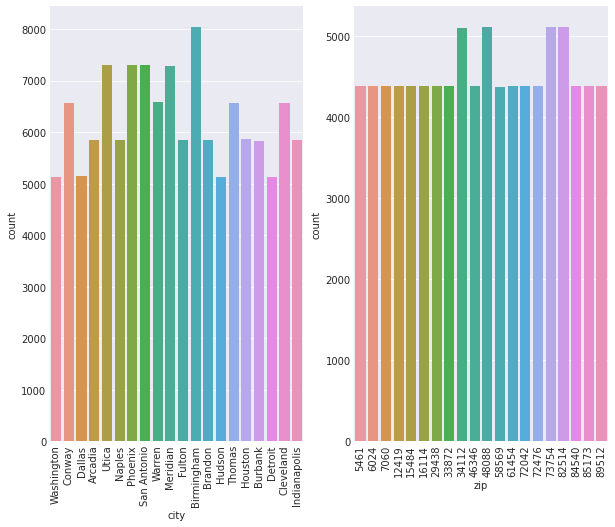

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
#plotting the cities transaction frequencies again
plots = []
plots.append(sns.countplot(df[df.city.isin(high_trans_cities)].city, ax=plt.subplot(121)))
plots.append(sns.countplot(df[df.zip.isin(high_trans_zips)].zip, ax=plt.subplot(122)))

for i in plots:
  i.set_xticklabels(i.get_xticklabels(), rotation=90)
plt.show()

- *Now, let us view the fraudulent transaction frequencies in each city through a dataframe.*

In [39]:
#constructing the city-transaction count distribution
df_city = df[['city','trans_num']].groupby(['city']).count().reset_index()
df_city.columns = ['city', 'city_count']

#creating the city-fraud distribution
df_fraud_city = df[['city', 'trans_num', 'is_fraud']].groupby(['city','is_fraud']).count().reset_index()
df_fraud_city.columns = ['city', 'is_fraud', 'Transaction count']

df_fraud_city = df_fraud_city.merge(df_city[['city', 'city_count']], how='inner', on='city')

df_fraud_city['Transaction percentage'] = (df_fraud_city['Transaction count']/df_fraud_city['city_count'])*100

#viewing the top 20 cities with high fraudulent transaction volumes
df_fraud_city[df_fraud_city['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,city,is_fraud,Transaction count,city_count,Transaction percentage
1322,Rice,1,8,8,100.000000
1106,Norfolk,1,7,7,100.000000
1325,Ridge Spring,1,10,10,100.000000
445,East China,1,9,9,100.000000
1294,Queen Anne,1,13,13,100.000000
1627,Waukau,1,10,10,100.000000
1247,Pleasant Hill,1,8,8,100.000000
528,Freeport,1,9,9,100.000000
1231,Phelps,1,11,11,100.000000
109,Beacon,1,11,11,100.000000


In [40]:
#constructing the zip-transaction count distribution
df_zip = df[['zip','trans_num']].groupby(['zip']).count().reset_index()
df_zip.columns = ['zip', 'zip_count']

#creating the zip-fraud distribution
df_fraud_zip = df[['zip', 'trans_num', 'is_fraud']].groupby(['zip','is_fraud']).count().reset_index()
df_fraud_zip.columns = ['zip', 'is_fraud', 'Transaction count']

df_fraud_zip = df_fraud_zip.merge(df_zip[['zip', 'zip_count']], how='inner', on='zip')

df_fraud_zip['Transaction percentage'] = (df_fraud_zip['Transaction count']/df_fraud_zip['zip_count'])*100

#viewing the top 20 zip codes with high fraudulent transaction volumes
df_fraud_zip[df_fraud_zip['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,zip,is_fraud,Transaction count,zip_count,Transaction percentage
1859,99921,1,14,14,100.000000
126,10533,1,8,8,100.000000
930,47842,1,12,12,100.000000
941,48054,1,9,9,100.000000
960,48436,1,8,8,100.000000
1035,52658,1,6,6,100.000000
1040,53045,1,9,9,100.000000
1052,53559,1,10,10,100.000000
234,14532,1,11,11,100.000000
1082,54980,1,10,10,100.000000


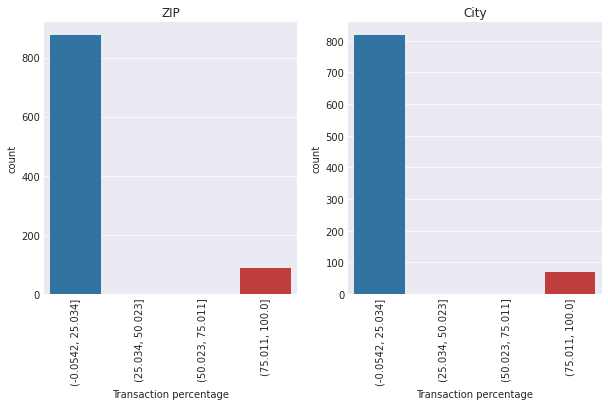

In [41]:
fig, ax = plt.subplots(figsize=(10,5))

plots = []
#plotting the fraudulent transactions percentage by binning

plots.append(sns.countplot(pd.cut(df_fraud_zip[df_fraud_zip.is_fraud == 1]['Transaction percentage'], bins = 4), ax=plt.subplot(121)))
plots.append(sns.countplot(pd.cut(df_fraud_city[df_fraud_city.is_fraud == 1]['Transaction percentage'], bins = 4), ax=plt.subplot(122)))

plots[0].set_title('ZIP')
plots[1].set_title('City')

for plot in plots:
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

In [42]:
#cities and zip codes with more fraudulent transactions
print('Cities with more than 75% fraudulent transactions:\n')
print(df_fraud_city.loc[(df_fraud_city.is_fraud == 1) & (df_fraud_city['Transaction percentage'] >= 75)].city.tolist())
print('\n\nZip codes with more than 75% fraudulent transactions:\n')
print(df_fraud_zip.loc[(df_fraud_zip.is_fraud == 1) & (df_fraud_zip['Transaction percentage'] >= 75)].zip.tolist())

Cities with more than 75% fraudulent transactions:

['Angwin', 'Ashland', 'Beacon', 'Brookfield', 'Bruce', 'Buellton', 'Byesville', 'Chattanooga', 'Clarion', 'Claypool', 'Clinton', 'Coulee Dam', 'Craig', 'Crouse', 'Downey', 'East China', 'Freeport', 'Gaines', 'Granbury', 'Greenport', 'Grenola', 'Grifton', 'Guthrie', 'Hubbell', 'Irvington', 'Isanti', 'Kaktovik', 'Karns City', 'Kirkwood', 'Kirtland', 'La Grande', 'Las Vegas', 'Lexington', 'Lockhart', 'Madisonville', 'Marshall', 'Medford', 'Melville', 'Mineral', 'Morrowville', 'Morven', 'Moss Point', 'Mount Vernon', 'Mountain City', 'Nanuet', 'Nicholson', 'Noblesville', 'Norfolk', 'North East', 'Oakton', 'Orange Park', 'Phelps', 'Pleasant Hill', 'Queen Anne', 'Rice', 'Ridge Spring', 'Roland', 'Seattle', 'Seligman', 'Senatobia', 'Springville', 'Streator', 'Vacaville', 'Walkertown', 'Wappapello', 'Wartburg', 'Waukau', 'West Frankfort', 'Wever', 'Winnsboro']


Zip codes with more than 75% fraudulent transactions:

[4032, 10018, 10533, 10553,

##### **Observation ('city' and 'zip' features):**
- from the above plot the places with high transaction frequencies can be observed.
- it is common knowledge that these zip codes and cities are some of the busiest places in the world which justifies the transaction frequencies in these areas.
- about 50 zip codes and 70 cities have more than 75% fradulent transactions.

##### **Inference:**
- The people in these area can be educated about the risks associated with using credit cards with respect to frauds.
- the monitoring of transactions can be increased in order to decrease the number of fraudulent transacions.

### **Exploring the Job feature:**

In [43]:
df.job.nunique()

497

- Similar to the 'city' and 'zip' features, the 'job' feature too has a lot of unique values which make it difficult for us to visualize and analyse the feature.
- Therefore, we will now only look at the top 20 jobs, people from which are transacting in high frequencies.

In [44]:
#fetching top 20 jobs with high transaction frequencies
high_trans_jobs = df.job.value_counts().head(20).index.tolist()
print(high_trans_jobs)

['Film/video editor', 'Exhibition designer', 'Surveyor, land/geomatics', 'Naval architect', 'Materials engineer', 'Designer, ceramics/pottery', 'Environmental consultant', 'Financial adviser', 'Systems developer', 'IT trainer', 'Copywriter, advertising', 'Scientist, audiological', 'Chartered public finance accountant', 'Chief Executive Officer', 'Podiatrist', 'Comptroller', 'Magazine features editor', 'Agricultural consultant', 'Paramedic', 'Sub']


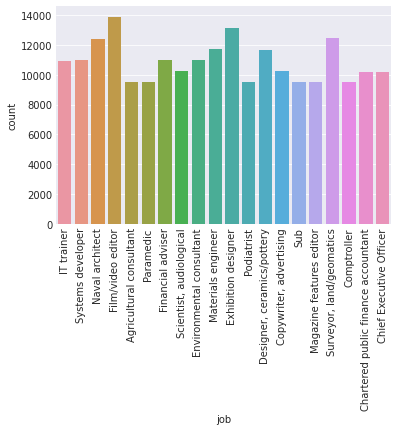

In [45]:
#plotting the transaction counts in the top 20 jobs
plot = sns.countplot(df[df.job.isin(high_trans_jobs)].job)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()

In [46]:
#constructing the zip-transaction count distribution
df_job = df[['job','trans_num']].groupby(['job']).count().reset_index()
df_job.columns = ['job', 'job_count']

#creating the zip-fraud distribution
df_fraud_job = df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
df_fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

df_fraud_job = df_fraud_job.merge(df_job[['job', 'job_count']], how='inner', on='job')

df_fraud_job['Transaction percentage'] = (df_fraud_job['Transaction count']/df_fraud_job['job_count'])*100

#viewing the top 20 jobs with high fraudulent transaction volumes
df_fraud_job[df_fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,job,is_fraud,Transaction count,job_count,Transaction percentage
444,Homeopath,1,11,11,100.000000
2,"Accountant, chartered",1,11,11,100.000000
393,Forest/woodland manager,1,9,9,100.000000
834,Software engineer,1,11,11,100.000000
827,Ship broker,1,7,7,100.000000
68,Armed forces technical officer,1,8,8,100.000000
228,Dancer,1,19,19,100.000000
796,Sales promotion account executive,1,14,14,100.000000
39,Air traffic controller,1,17,17,100.000000
99,Broadcast journalist,1,9,9,100.000000


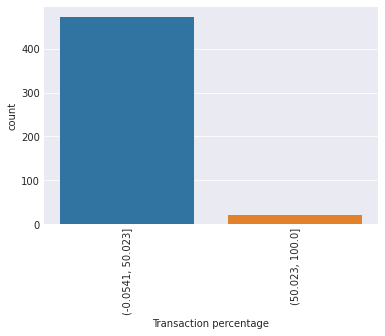

In [47]:
#plotting the fraudulent transactions percentage by binning
plot = sns.countplot(pd.cut(df_fraud_job[df_fraud_job.is_fraud == 1]['Transaction percentage'], bins = 2))
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [48]:
#job with more than one percent fraudulent transactions
df_fraud_job.loc[(df_fraud_job.is_fraud == 1) & (df_fraud_job['Transaction percentage'] >= 50)].job

2                  Accountant, chartered
39                Air traffic controller
68        Armed forces technical officer
99                  Broadcast journalist
118                      Careers adviser
207           Contracting civil engineer
228                               Dancer
335                       Engineer, site
340                      Engineer, water
393              Forest/woodland manager
444                            Homeopath
475                     Industrial buyer
478                  Information officer
521                      Legal secretary
624        Operational investment banker
651                    Personnel officer
796    Sales promotion account executive
827                          Ship broker
834                    Software engineer
837                            Solicitor
947                   Veterinary surgeon
956                    Warehouse manager
Name: job, dtype: object

##### **Observation ('job' feature):**
- The above are the jobs where in high transaction frequencies have been noted.
- In the above dataframe, the transactions containing the job feature value as-Armed forces technical officer;	Engineer, site; Information officer; Legal secretary;	Industrial buyer; Careers adviser; Homeopath; Broadcast journalist; Personnel officer; Forest/woodland manager;	Sales promotion account executive;	Air traffic controller;	Contracting civil engineer;	Ship broker;	Solicitor;2	Accountant, chartered;	Dancer;	Warehouse manager;	Veterinary surgeon have *completely fraudulent transactions*.

##### **Inference:**
- The people in the jobs with high number of fraudulent transactions can be alerted about the credit card transaction frauds so that they can be more carefull while using their credit cards.
- the jobs roles in which almost all transactions are fraudulent might mean that there is some fault with the datapoint. That is, the person representing the specific job might be at fault since it is highly unlikely that all the transactions made by a person from a spceific job are fraudulent. Hence, doing some kind of background check upon the credit card user might help in this case.

### **Exploring the 'category' feature:**

- This feature details the category for which the particular transaction of the data point has been done.

In [49]:
df.category.value_counts(normalize=True)

gas_transport    0.101506
grocery_pos      0.095115
home             0.094721
shopping_pos     0.089864
kids_pets        0.087307
shopping_net     0.075212
entertainment    0.072403
food_dining      0.070573
personal_care    0.070225
health_fitness   0.066159
misc_pos         0.061666
misc_net         0.048939
grocery_net      0.035024
travel           0.031287
Name: category, dtype: float64

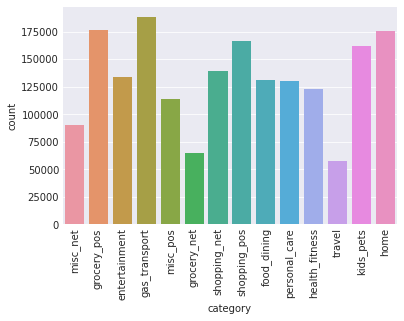

In [50]:
#plotting the category wise counts
plot = sns.countplot(df.category)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

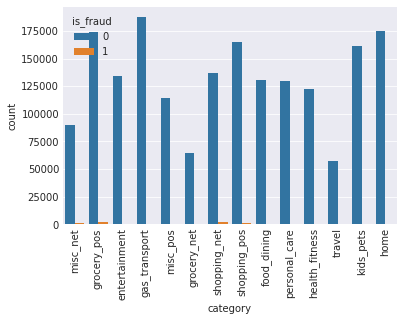

In [51]:
#let us see the number of fraudulent transaction in these categories
plot = sns.countplot(df.category, hue=df.is_fraud)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

In [52]:
#constructing the category-transaction count distribution
df_category = df[['category','trans_num']].groupby(['category']).count().reset_index()
df_category.columns = ['category', 'category_count']

#creating the zip-fraud distribution
df_fraud_category = df[['category', 'trans_num', 'is_fraud']].groupby(['category','is_fraud']).count().reset_index()
df_fraud_category.columns = ['category', 'is_fraud', 'Transaction count']

df_fraud_category = df_fraud_category.merge(df_category[['category', 'category_count']], how='inner', on='category')

df_fraud_category['Transaction percentage'] = (df_fraud_category['Transaction count']/df_fraud_category['category_count'])*100

#viewing the top categories with high fraudulent transaction volumes
df_fraud_category[df_fraud_category['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False)

,category,is_fraud,Transaction count,category_count,Transaction percentage
23,shopping_net,1,2219,139322,1.592713
17,misc_net,1,1182,90654,1.303859
9,grocery_pos,1,2228,176191,1.264537
25,shopping_pos,1,1056,166463,0.634375
5,gas_transport,1,772,188029,0.410575
19,misc_pos,1,322,114229,0.281890
7,grocery_net,1,175,64878,0.269737
27,travel,1,156,57956,0.269170
21,personal_care,1,290,130085,0.222931
1,entertainment,1,292,134118,0.217719


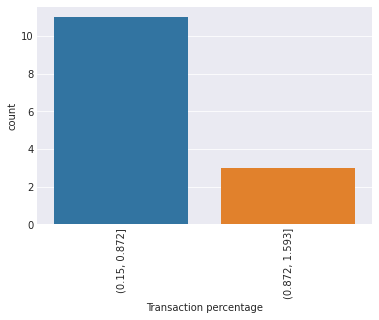

In [53]:
#plotting the fraudulent transactions percentage by binning
plot = sns.countplot(pd.cut(df_fraud_category[df_fraud_category.is_fraud == 1]['Transaction percentage'], bins = 2))
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [54]:
#categories with more than one percent fraudulent transactions
df_fraud_category.loc[(df_fraud_category.is_fraud == 1) & (df_fraud_category['Transaction percentage'] >= 1)].category

9      grocery_pos
17        misc_net
23    shopping_net
Name: category, dtype: object

In [55]:
df_fraud_category.head()

,category,is_fraud,Transaction count,category_count,Transaction percentage
0,entertainment,0,133826,134118,99.782281
1,entertainment,1,292,134118,0.217719
2,food_dining,0,130524,130729,99.843187
3,food_dining,1,205,130729,0.156813
4,gas_transport,0,187257,188029,99.589425


###### **Observation ('category' feature):**
- from the above plots and dataframes created, it can be observed that about 3 categories have more than 1% fraudulent transactions involved. These are - grocery_pos, misc_net, shopping_net.
- out these, the shopping_net category has the most number of fraudulent transactions.

###### **Inference:**
- From the above observations, it can be inferred that, most of the fraudulent transactions are taking place in the shopping_net category. It is possible that the fruadsters have placed certain defective transaction equipments or other mechanisms which have increased the number of fraudulent transactions.
- therefore, the above mentioned categories can be checked thoroughly in order to reduce the fraud percentage.

### **Exploring 'Merchant' Feature:**

In [56]:
df.merchant.nunique()

693

- It can be observed that there are more than 600 unique values. This makes it inconvienient to plot and analyze.
- Therefore, we will only analyze the top merchants with highest number of fraudulent transactions.

In [57]:
high_trans_merchants = df.merchant.value_counts().head(20).index.tolist()
high_trans_merchants

['fraud_Kilback LLC',
 'fraud_Cormier LLC',
 'fraud_Schumm PLC',
 'fraud_Kuhn LLC',
 'fraud_Boyer PLC',
 'fraud_Dickinson Ltd',
 'fraud_Emard Inc',
 'fraud_Cummerata-Jones',
 'fraud_Corwin-Collins',
 'fraud_Rodriguez Group',
 'fraud_Kling Inc',
 'fraud_Parisian and Sons',
 'fraud_Erdman-Kertzmann',
 'fraud_Huels-Hahn',
 'fraud_Stroman, Hudson and Erdman',
 'fraud_Kutch LLC',
 'fraud_Jenkins, Hauck and Friesen',
 'fraud_Prohaska-Murray',
 'fraud_Olson, Becker and Koch',
 'fraud_Eichmann, Bogan and Rodriguez']

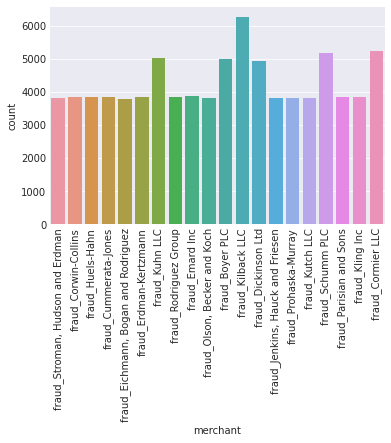

In [58]:
#plotting the top merchants with high transaction volumes
plot = sns.countplot(df[df.merchant.isin(high_trans_merchants)].merchant)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

In [59]:
#constructing the merchant-transaction count distribution
df_merchant = df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['merchant', 'merchant_count']

#creating the zip-fraud distribution
df_fraud_merchant = df[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['merchant', 'is_fraud', 'Transaction count']

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['merchant', 'merchant_count']], how='inner', on='merchant')

df_fraud_merchant['Transaction percentage'] = (df_fraud_merchant['Transaction count']/df_fraud_merchant['merchant_count'])*100

#viewing the top 20 merchant with high fraudulent transaction volumes
df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,merchant,is_fraud,Transaction count,merchant_count,Transaction percentage
673,fraud_Kozey-Boehm,1,60,2758,2.175489
490,"fraud_Herman, Treutel and Dickens",1,38,1870,2.032086
1226,fraud_Terry-Huel,1,56,2864,1.955307
607,fraud_Kerluke-Abshire,1,50,2635,1.897533
884,"fraud_Mosciski, Ziemann and Farrell",1,53,2821,1.878766
1105,"fraud_Schmeler, Bashirian and Price",1,52,2788,1.865136
691,fraud_Kuhic LLC,1,53,2842,1.864884
563,fraud_Jast Ltd,1,51,2757,1.849837
743,"fraud_Langworth, Boehm and Gulgowski",1,52,2817,1.845935
1051,"fraud_Romaguera, Cruickshank and Greenholt",1,51,2767,1.843151


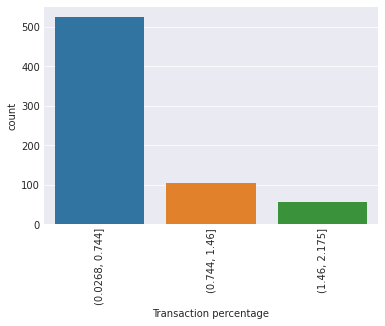

In [60]:
#plotting the fraudulent transactions percentage by binning
plot = sns.countplot(pd.cut(df_fraud_merchant[df_fraud_merchant.is_fraud == 1]['Transaction percentage'], bins = 3))
plot.set_xticklabels(plot.get_xticklabels(), rotation = 90)
plt.show()

In [61]:
#number of merchants with more than one percent fraudulent transactions
len(df_fraud_merchant.loc[(df_fraud_merchant.is_fraud == 1) & (df_fraud_merchant['Transaction percentage'] >= 1)].merchant)

139

In [62]:
#number of merchants with more than one percent fraudulent transactions
df_fraud_merchant.loc[(df_fraud_merchant.is_fraud == 1) & (df_fraud_merchant['Transaction percentage'] >= 2)].merchant

490    fraud_Herman, Treutel and Dickens
673                    fraud_Kozey-Boehm
Name: merchant, dtype: object

##### **Observation ('merchant' feature):**
- from the above plots and dataframes created, it can be observed that aboout 140 merchants have more than 1% transactions associated with them as fraudulent transactions.
- Also, the merchants fraud_Brown PLC; fraud_Goyette Inc; fraud_Herman; Treutel and Dickens; fraud_Jast Ltd; fraud_Kerluke-Abshire; fraud_Kozey-Boehm; fraud_Schmeler, Bashirian and Price; fraud_Terry-Huel are top merchants with highest number of fraudulent transactions.

##### **Inference:**
- The aforementioned merchants can be checked for fraudulent practices.
- They also can be alerted about the fraudulent practices happening and be educated about how to avoid them.

###### *Now that we are done with the EDA process we will now proceed with creating the dummy variables and encoding the features where ever require in our dataset.*

# **Step - 4: Feature Encoding**

*one hot encoding*

In [63]:
#one-hot encoding the category variable
category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
#one-hot encoding the gender variable
gender_onehot = pd.get_dummies(df.gender, prefix='gender', drop_first=True)
#one-hot encoding the day_of_week variable
day_of_week_onehot = pd.get_dummies(df.trans_day_of_week, prefix='day', drop_first=True)
#one-hot encoding the age variable
age_onehot = pd.get_dummies(df.age, prefix='age', drop_first=True)

In [64]:
df1 = pd.concat([df, category_onehot,gender_onehot,day_of_week_onehot,age_onehot], axis=1)

df1.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,age_46-60,age_61-75,age_< 30,age_> 75
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,30-45,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,30-45,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,46-60,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,46-60,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,30-45,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


- Now, some features like 'cc_num', 'first', 'last', 'trans_num' are not significant in context of our analysis and hence can be removed.

In [65]:
df1.drop([ 'cc_num', 'trans_num'], axis=1, inplace=True)
print(df1.shape)
df1.columns

(1852394, 44)


Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'trans_day_of_week',
       'trans_year_month', 'age', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30', 'age_> 75'],
      dtype='object')

- In the above df1 Dataframe, the feature 'merchant' can be dropped since it has lot of unique values and it is hard to encode all of them. And the same applies to the variables - 'street', 'city', 'state' and 'job'
- Similarly, the variables - 'age', 'category', 'gender', 'trans_day_of_week' can also be dropped since they have already been encoded.

In [66]:
df1.drop(['merchant','street','city','state','job',
          'category','gender','trans_day_of_week',
          'age'],axis=1, inplace=True)
df1.columns

Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'trans_year_month',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30',
       'age_> 75'],
      dtype='object')

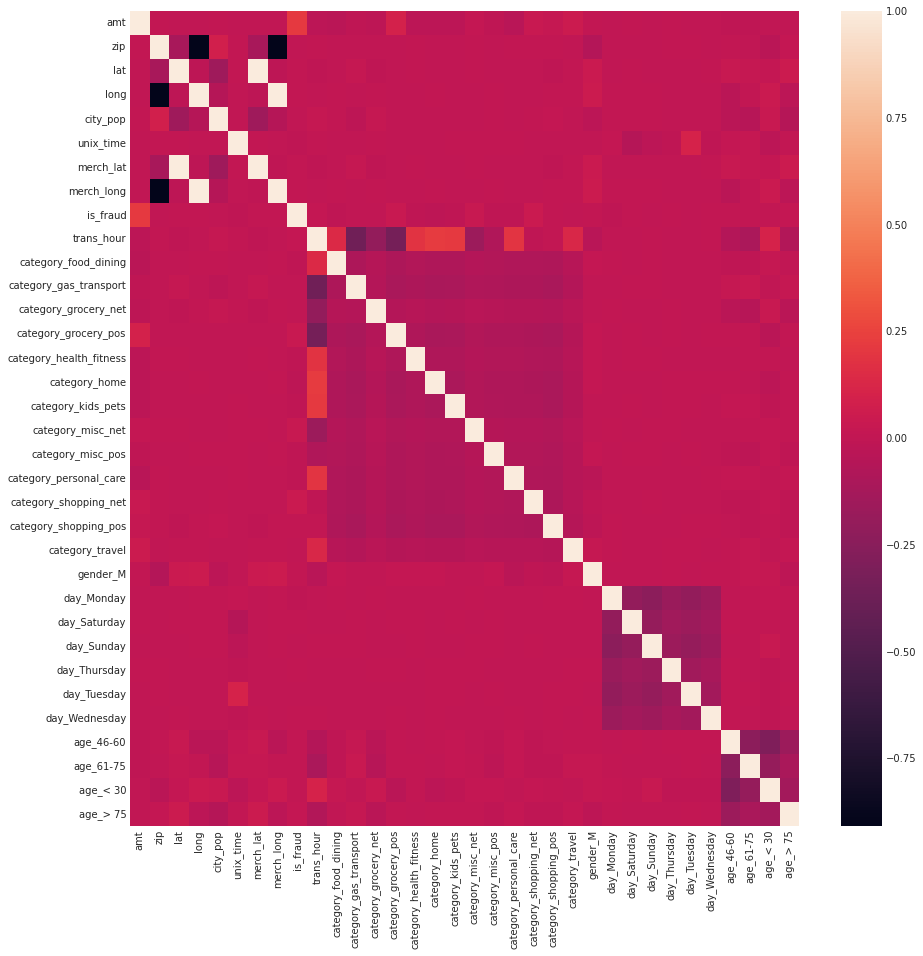

In [67]:
#let us now check the correlations between the columns
df_random_under_corr = df1.corr()
#plotting the correlation heatplot
plt.figure(figsize=(15,15))
sns.heatmap(df_random_under_corr)
plt.show()

- Now, since there are a lot of variables let us get the variables that have high correlation using a function that outputs the variables with correlation between them above a certain threshold.

In [68]:
#function to return highly correlated column above a threshold
def correlation(dataset, threshold):
    col_corr = set() # This set stores the highly correlated columns
    corr_matrix = dataset.corr() #correlation matrix
    #traversing the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                colname = corr_matrix.columns[i] #selecting columns above threshold
                col_corr.add(colname) #adding columns to set
    return col_corr

In [69]:
#let us get the features with correlation above 85%
corr_features = correlation(df1,0.85)
corr_features

{'merch_lat', 'merch_long'}

- As it can be seen, there are no features that have a correlation of above 85%. Hence, it is safe to proceed with out model building.

# **Step - 5: Implementing Algorithms**

In [70]:
#storing the number of values in each class
non_fraud_count, fraud_count = df1.is_fraud.value_counts()

In [71]:
#storing the numerical columns of the data and removing unnecessary variables
df_num = df1.select_dtypes(include='number')
df_num.drop(['zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat','merch_long'],
            axis=1, inplace=True)
df_num.columns

Index(['amt', 'is_fraud', 'trans_hour', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30', 'age_> 75'],
      dtype='object')

In [72]:
#innput-output split
X = df_num.drop(['is_fraud'],axis=1)
y = df_num.is_fraud

*Scaling the values:*

In [73]:
#scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

### **Logistic Regression**

In [74]:
#train-test split using stratified K fold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X,y)

for train_index, test_index in skf.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

y_train.value_counts()

0    921372
1      4825
Name: is_fraud, dtype: int64

- ***Implementing Logistic Regression algorithm on the dataframe.***

- As it can be seen, the classes in the target variable are imbalance. We need to fix this later.

In [75]:
lr = LogisticRegression(random_state=42)
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('y_train_pred: ',y_train_pred)
y_test_pred = model.predict(X_test)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 0 ... 0 0 0]
y_test_pred:  [0 0 0 ... 0 0 0]


In [76]:
#evaluating the model
model_name = 'Logistic Regression - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#creating a dataframe to compare the performance of different models
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072


### **Impacts of Imbalance:**
- From the above dataframe it can be seen that although we have not balanced the classes in our target variable, the accuracy and several other metrics seem to look great.
- This is because, since there is no balance in the dataset at this point, the model predicts almost all data points as 'not fraud'.
- This does not clearly satify our motive hence, we need to balance the classes in the target variable in order build a fair model.

#### *Feature Balancing*
- in this, we will only use the X_train and y_train obtained from the stratified k-Fold split that we have obtained above and use the X_test and y_test to test our models on unseen data.
- We will also only balance the data points in X_train and y_train datasets and test our model upon the imbalanced data of X_test and y_test.
- Hence, we will store X_test and y_test as test_input and test_output for better understanding.

In [77]:
#renaming X_test and y_test variables
test_input = X_test.copy()
test_output = y_test.copy()

test_output.value_counts(normalize=True)

0   0.994789
1   0.005211
Name: is_fraud, dtype: float64

In [78]:
#storing all fraud transactions
fraud_trans = df_num[df_num['is_fraud'] == 1]
non_fraud_trans = df_num[df_num['is_fraud'] == 0]

print('fraud data shape: ', fraud_trans.shape)
print('non fraud data shape: ', non_fraud_trans.shape)

#printing fraud data percentage
print('Fraud Data percentage: ', 100*(len(fraud_trans)/len(non_fraud_trans)))

fraud data shape:  (9651, 27)
non fraud data shape:  (1842743, 27)
Fraud Data percentage:  0.5237301132062366


**Notes:**
- it can be observed from the above step that the dataframe is highly imbalanced.
- the number of fraudulent transactions are only about 0.5% of the total dataset.
- This imbalance might create bias in our model building process
- Therefore, we will have to balance the dataset by performing oversampling or undersampling.
- And, we will use the stratified k-fold cross validation for training and validating our model with each algorithm used to build the model.

***We can use 2 methods for handling imbalanced data: 1) Undersampling and 2)Oversampling.***

**1) Undersampling - *Random Undersampling:***
- *for this, we will use the sample method to randomly choose the total number of data points from majority class as in the minority class.*

In [79]:
#random under sampling using imblearn
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

y_rus.value_counts()

0    4825
1    4825
Name: is_fraud, dtype: int64

* Now, we will do the train-test split with the argument 'stratify' in the method equal to our target variable, in order to have equal number of samples from each class in our split.

*Train-Test Split:*

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42, stratify=y_rus)

In [81]:
y_train.value_counts()

1    3378
0    3377
Name: is_fraud, dtype: int64

*Let us now build a baseline Linear model to analyze this data **after undersampling** .*

In [82]:
#creating a baseline linear model
lr = LogisticRegression(random_state=42)
#model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([1, 1, 0, ..., 1, 0, 0])

In [83]:
#predicting on imbalanced test data
test_pred=model.predict(test_input)
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [84]:
#printing the classification report of the model
print(classification_report(test_output,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    921371
           1       0.03      0.75      0.05      4826

    accuracy                           0.86    926197
   macro avg       0.51      0.81      0.49    926197
weighted avg       0.99      0.86      0.92    926197



In [85]:
#evaluating the model
model_name = 'Logistic Regression - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455


- It can be noted from the above dataframe that although the accuracy, the training and testing scores and the F1 score metrics have dropped, the precision and recall have improved which are much more important metrics to evaluate a classification model.

**2) Oversampling -  *Random Over Sampling*:**

In [86]:
#oversampling with imblearn
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

y_ros.value_counts()

1    3378
0    3378
Name: is_fraud, dtype: int64

In [87]:
#train Test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, stratify=y_ros, random_state=42)
y_train.value_counts()

1    2365
0    2364
Name: is_fraud, dtype: int64

In [88]:
#implementing logistic regression
lr = LogisticRegression(random_state=42)
#creating model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
test_pred = model.predict(test_input)
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [90]:
#printing classification report
print(classification_report(test_output, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93    921371
           1       0.03      0.76      0.05      4826

    accuracy                           0.86    926197
   macro avg       0.51      0.81      0.49    926197
weighted avg       0.99      0.86      0.92    926197



In [91]:
#evaluating the model
model_name = 'Logistic Regression - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257


**3) Oversampling - *SMOTE method*:**

In [92]:
#balancing using SMOTE method
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train.astype('float'), y_train)

y_sm.value_counts()

1    2365
0    2365
Name: is_fraud, dtype: int64

In [93]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm)
y_train.value_counts()

1    1656
0    1655
Name: is_fraud, dtype: int64

In [94]:
#implementing logistic regression
lr = LogisticRegression(random_state=42)
#creating model
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 1, 0, ..., 1, 0, 1])

In [95]:
test_pred = model.predict(test_input)
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [96]:
#printing classification report
print(classification_report(test_output, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92    921371
           1       0.03      0.78      0.05      4826

    accuracy                           0.85    926197
   macro avg       0.51      0.82      0.49    926197
weighted avg       0.99      0.85      0.92    926197



In [97]:
#evaluating the model
model_name = 'Logistic Regression - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077


###### **Observation:**

- Here, it can be observed that the 'Random Under Sampling' method has produced better results.
- However, there is a problem with the Random Under sampling method. That is, while trimming the data to balance the classes in the target varibale, there is problem of losing valuable data.
- But, the results produced by the model with 'over sampling' can be observed to be equally efficient.
- And, ideally, the SMOTE method can be used, because it has produced a slightly better Recall.

### **Note:**
- **From now on, we will use (X,y), (X_rus,y_rus), (X_ros,y_ros), (X_sm,y_sm) where ever normal, Random Under sampled, Random Over sampled and SMOTE sampled data is required respectively.**

### **Decision Trees**

In [98]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

#evaluating the model
model_name = 'Decision Tree - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.92      0.75      0.83      2938

    accuracy                           1.00    555719
   macro avg       0.96      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574


- From above, it can be understood that Decision trees cannot handle imbalanced data efficiently which can be observed from the recall score. Hence, we will now balance the variable and try again.
- For this we can use the variables we have created above for different sampling methods.

***Implementing Decision Tree Classifier upon under and oversampled data respectively.***

***Undersampling:***

In [99]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    921371
           1       0.09      0.97      0.17      4826

    accuracy                           0.95    926197
   macro avg       0.55      0.96      0.57    926197
weighted avg       1.00      0.95      0.97    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369


***Oversampling:***

In [100]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    921371
           1       0.12      0.96      0.21      4826

    accuracy                           0.96    926197
   macro avg       0.56      0.96      0.59    926197
weighted avg       1.00      0.96      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215


***Oversampling SMOTE:***

In [101]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Decision Tree - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    921371
           1       0.09      0.97      0.16      4826

    accuracy                           0.95    926197
   macro avg       0.54      0.96      0.57    926197
weighted avg       1.00      0.95      0.97    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603


- From above, it can be observed that the 'Radom Over sampling' method of balancing the variables is efficient. And clearly, the **Decision Tree** model is the best model untill now.
- However, we will choose the SMOTE method since all the other metrics are at almost similar or better level than all the other sampling methods.

- *We will now implement the **'Random Forest'** Algorithm from the ensemble library.*

### **Random Forest:**

In [102]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

#evaluating the model
model_name = 'Random Forest - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.88      0.76      0.82      2938

    accuracy                           1.00    555719
   macro avg       0.94      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603
8,Random Forest - without balancing,0.999981,0.998199,0.998199,0.998130,0.884783,0.757999


***Implementing Random Forest Classifier upon under and oversampled data respectively.***

***Undersampling:***

In [103]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    921371
           1       0.15      0.96      0.26      4826

    accuracy                           0.97    926197
   macro avg       0.58      0.97      0.63    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603
8,Random Forest - without balancing,0.999981,0.998199,0.998199,0.998130,0.884783,0.757999
9,Random Forest - Random Under Sampling,1.000000,0.973057,0.972121,0.982034,0.153445,0.963116


***Oversampling:***

In [104]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    921371
           1       0.14      0.97      0.24      4826

    accuracy                           0.97    926197
   macro avg       0.57      0.97      0.61    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603
8,Random Forest - without balancing,0.999981,0.998199,0.998199,0.998130,0.884783,0.757999
9,Random Forest - Random Under Sampling,1.000000,0.973057,0.972121,0.982034,0.153445,0.963116


***Oversampling - SMOTE:***

In [105]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - SMOTE'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    921371
           1       0.14      0.96      0.24      4826

    accuracy                           0.97    926197
   macro avg       0.57      0.96      0.61    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603
8,Random Forest - without balancing,0.999981,0.998199,0.998199,0.998130,0.884783,0.757999
9,Random Forest - Random Under Sampling,1.000000,0.973057,0.972121,0.982034,0.153445,0.963116


- From the above Dataframe, it can be noted that the **Random Forest Algorithm** is the best among all the others that we have used for model building.
- Out of all the sampling methods, the random forests method has yielded best results with the random Oversampling sampling algorithm.
- However, we will use the SMOTE sampling algorithm for our model. This is because, unlike the random over sampling algorithm which just creates duplicates of existing values, SMOTE algorithm creates values according to its neighbours. Therefore, SMOTE algorithm is much more reliable for model building.

- We will now perform hyper-parameter tuning for our model with Random Forest Algorithm and SMOTE sampling method.

### **Hyper-parameter Tuning for Random Forest:**

In [106]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

print(grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [107]:
'''#implementing Grid Search CV on Random Forest classifier
rf = RandomForestClassifier()

clf = GridSearchCV(rf, grid, cv=5, n_jobs=-1, verbose=4, return_train_score=True)

#fitting the model
clf.fit(X_train, y_train)

cv_result = pd.DataFrame(clf.cv_results_)
print(cv_result)

print('Best params: ',clf.best_params_)
print('Best score: ', clf.best_score_)

#best grid
best_grid = grid.best_estimator_
best_grid'''

"#implementing Grid Search CV on Random Forest classifier\nrf = RandomForestClassifier()\n\nclf = GridSearchCV(rf, grid, cv=5, n_jobs=-1, verbose=4, return_train_score=True)\n\n#fitting the model\nclf.fit(X_train, y_train)\n\ncv_result = pd.DataFrame(clf.cv_results_)\nprint(cv_result)\n\nprint('Best params: ',clf.best_params_)\nprint('Best score: ', clf.best_score_)\n\n#best grid\nbest_grid = grid.best_estimator_\nbest_grid"

### **Note:**
- The above code has been commented because, it will take a lot of time and RAM to execute it.
- Therefore, we will just use the 'Best parameters' found after the Hyperparameter Tuning.
- The best parameters are: **`RandomForestClassifier(max_features='sqrt', n_estimators = 200)`**

- ***Let us now train the model with the best parameters found using GridSearchCV.***

In [108]:
best_grid = RandomForestClassifier(max_features = 'sqrt', n_estimators=200, random_state=42)
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm, test_size=0.3, random_state=42)

model = best_grid.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - SMOTE [Hyperparameter Tuned]'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    921371
           1       0.14      0.96      0.25      4826

    accuracy                           0.97    926197
   macro avg       0.57      0.97      0.62    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.811547,0.815889,0.864707,0.922593,0.028498,0.754455
2,Logistic Regression - Random Over Sampling,0.813068,0.813518,0.862561,0.921354,0.028265,0.760257
3,Logistic Regression - SMOTE,0.821806,0.804087,0.853416,0.916040,0.027122,0.778077
4,Decision Tree - without balancing,0.998524,0.998343,0.998343,0.998261,0.918291,0.753574
5,Decision Tree - Random Under Sampling,0.982235,0.955786,0.950678,0.970392,0.093246,0.970369
6,Decision Tree - Random Over Sampling,0.989850,0.962506,0.962189,0.976612,0.117429,0.960215
7,Decision Tree - SMOTE,0.989127,0.961945,0.948630,0.969282,0.089490,0.965603
8,Random Forest - without balancing,0.999981,0.998199,0.998199,0.998130,0.884783,0.757999
9,Random Forest - Random Under Sampling,1.000000,0.973057,0.972121,0.982034,0.153445,0.963116


# **Conclusion**:
## **Exploratory Data Analysis:**
- various features of the data set have been analyzed and several insights have been obtained.
- The 'trans_date_trans_time' feature has been broken down into several components like 'Age', 'day of the week', 'month' in order to facilitate our analysis.
- These features have been thoroughly analyzed. It has been found that most transaction are being done after 12 noon and that during holiday seasons, the number of transaction along with the number of fraudulent transactions will increase.
- Old age people above 75 years are more susseptible to frauds. This is because, fraudsters might try to take advantage of their lack of knowledge about the constantly changing ways of how transactions are made.
- The 'Female' gender people have been observed to do much of the transaction according to the dataset. Hence, transactions involving might be much prone to fraud.
- Also, by analyzing several demographic variables like city, state, zip etc it has been found that, several places like 'DE' state has 100% fraud rate and about 50 zip codes and 70 cities have 100% fraud rate. There might be some ill practices happening at the ground level at these places since all the transactions happening there are shown as fraudulent.
- Similarly, several job profiles wherein a 100% fraud rate is seen can also be checked for descripencies.
- In the categories feature, gas_transport, grocery_pos, home, shopping_pos, 
kids_pets are the top 5 most categories with most fraud rates. Most of these categories seem to involve either an online transaction sale or a POS sale. There might be some issue on those fronts like tampered POS machines, or hacked transaction gateway which can be checked by the company.
- In the Merchant category the merchants fraud_Kozey-Boehm;	fraud_Herman, Treutel and Dickens have a higher than usual amount of fraudulent transactions associated with them. And hence, even they can be checked for malpractices.

## **Model Building:**
- The features 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat','merch_long' have been asumed to provide no significant information in the model building phase. Hence, they along with the original features that have been encoded have been dropped from the dataset.
- 3 different algorithms have been implemented upon the processed dataset.
- 3 sampling techniques in order to balance the dataset have also been implemented.
- The algorithms have also been implemented upon the dataset before balancing the dataset for demonstration purposes.
- Hence, about 12 different models have been created the results of which have been summarized above.
- Out of the 12 models that have been built, the **Random Forest Classifier** built using the **SMOTE** sampling technique after hyper parameter tuning has provided us the most preferable model with a recall of 0.99, f1 score of 0.99 and precision of 0.99.

- **Hence, it can be said the the `Radom Forest Classifier - SMOTE sampling` is the best model.**